In [2]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
# Загрузка данных
df_train = pd.read_csv('/content/BATADAL_dataset03.csv', sep=',')
df_test = pd.read_csv('/content/BATADAL_dataset04.csv', sep=',')
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

In [6]:
# Очистка данных
df_train = df_train[df_train['DATETIME'] != 'DATETIME']
df_test = df_test[df_test['DATETIME'] != 'DATETIME']

print("Columns:", df_train.columns.tolist())
print("Train data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

Columns: ['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']
Train data shape: (8761, 45)
Test data shape: (4177, 45)


In [7]:
# Подготовка тренировочных данных (только нормальные данные)
X_train = df_train.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
y_train = df_train['ATT_FLAG'].astype(int)  # Все равны 0

In [8]:
# Подготовка тестовых данных
# Сначала посмотрим на распределение меток в тестовых данных
print("Test data ATT_FLAG distribution:")
print(df_test['ATT_FLAG'].value_counts())

# Возьмем ВСЕ данные из тестового набора, включая -999
# Будем считать -999 как потенциальные аномалии для проверки
X_test = df_test.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
y_test_raw = df_test['ATT_FLAG']

# Создадим маску для известных меток (0 и 1)
known_mask = df_test['ATT_FLAG'].isin([0, 1])
y_test_known = y_test_raw[known_mask].astype(int)

print(f"Known labels distribution: {np.bincount(y_test_known)}")
print(f"Unknown labels (-999): {(y_test_raw == -999).sum()}")

# Для первоначального анализа используем только известные метки
X_test_known = X_test[known_mask]
y_test = y_test_known

print(f"Train: {X_train.shape[0]} samples (all normal)")
print(f"Test: {X_test_known.shape[0]} samples")
print(f"Test labels distribution: {np.bincount(y_test) if len(y_test) > 0 else 'No labels'}")


Test data ATT_FLAG distribution:
ATT_FLAG
-999    3958
 1       219
Name: count, dtype: int64
Known labels distribution: [  0 219]
Unknown labels (-999): 3958
Train: 8761 samples (all normal)
Test: 219 samples
Test labels distribution: [  0 219]


In [9]:
# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_known_scaled = scaler.transform(X_test_known)

# Конвертация в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_known_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"Feature dimensions: {X_train_tensor.shape[1]}")


Feature dimensions: 43


In [10]:
# =============================================================================
# SNN AUTOENCODER ARCHITECTURE
# =============================================================================

class SNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(SNNAutoencoder, self).__init__()

        # Суррогатная функция градиента
        self.spike_grad = surrogate.fast_sigmoid()

        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_lif1 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        self.encoder_fc2 = nn.Linear(hidden_dim, latent_dim)
        self.encoder_lif2 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lif1 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)
        self.decoder_lif2 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

    def forward(self, x, num_steps=25):
        batch_size = x.shape[0]

        # Инициализация для записи спайков
        latent_spikes = []
        output_spikes = []

        for step in range(num_steps):
            # Encoder
            cur1 = self.encoder_fc1(x)
            spk1 = self.encoder_lif1(cur1)

            cur2 = self.encoder_fc2(spk1)
            spk2 = self.encoder_lif2(cur2)  # Latent representation

            # Decoder
            cur3 = self.decoder_fc1(spk2)
            spk3 = self.decoder_lif1(cur3)

            cur4 = self.decoder_fc2(spk3)
            spk4 = self.decoder_lif2(cur4)  # Reconstructed output

            latent_spikes.append(spk2)
            output_spikes.append(spk4)

        # Возвращаем суммарные значения спайков вместо средних для более стабильных результатов
        latent_output = torch.stack(latent_spikes).sum(0)
        reconstructed_output = torch.stack(output_spikes).sum(0)

        return reconstructed_output, latent_output

    def reset_hidden(self):
        self.encoder_lif1.reset_hidden()
        self.encoder_lif2.reset_hidden()
        self.decoder_lif1.reset_hidden()
        self.decoder_lif2.reset_hidden()

In [11]:
# =============================================================================
# TRAINING SETUP
# =============================================================================

# Параметры модели
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
latent_dim = 64

model = SNNAutoencoder(input_dim, hidden_dim, latent_dim).to(device)

# Параметры обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader для тренировки
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [12]:
# =============================================================================
# TRAINING LOOP
# =============================================================================

num_epochs = 50
num_steps = 25

print("Starting training...")
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (batch_x,) in enumerate(train_loader):
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        model.reset_hidden()

        # Forward pass
        reconstructed, latent = model(batch_x, num_steps=num_steps)

        # Reconstruction loss
        loss = criterion(reconstructed, batch_x)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.6f}")

print("Training completed!")

Starting training...
Epoch [10/50] - Avg Loss: 0.542427
Epoch [20/50] - Avg Loss: 0.540327
Epoch [30/50] - Avg Loss: 0.541990
Epoch [40/50] - Avg Loss: 0.543782
Epoch [50/50] - Avg Loss: 0.542107
Training completed!


In [13]:
# =============================================================================
# ANOMALY DETECTION
# =============================================================================

def calculate_reconstruction_error(model, data_loader, device, num_steps=25):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for batch_x, in data_loader:
            batch_x = batch_x.to(device)
            model.reset_hidden()

            reconstructed, _ = model(batch_x, num_steps=num_steps)

            # Вычисляем MSE для каждого образца
            mse = torch.mean((batch_x - reconstructed) ** 2, dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    return np.array(reconstruction_errors)

# Вычисляем reconstruction error для тренировочных данных (только нормальные)
train_loader_for_eval = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=False)
train_errors = calculate_reconstruction_error(model, train_loader_for_eval, device, num_steps)

# Вычисляем reconstruction error для тестовых данных
test_loader_for_eval = DataLoader(TensorDataset(X_test_tensor), batch_size=batch_size, shuffle=False)
test_errors = calculate_reconstruction_error(model, test_loader_for_eval, device, num_steps)

# Определяем порог более консервативно
# Попробуем разные процентили для лучшего баланса
percentiles = [90, 95, 97, 99]
thresholds = [np.percentile(train_errors, p) for p in percentiles]

print("Different threshold options:")
for p, t in zip(percentiles, thresholds):
    pred = (test_errors > t).astype(int)
    if len(np.unique(y_test)) > 1:
        from sklearn.metrics import precision_score, recall_score
        prec = precision_score(y_test, pred, zero_division=0)
        rec = recall_score(y_test, pred, zero_division=0)
        print(f"{p}th percentile: {t:.6f} - Precision: {prec:.3f}, Recall: {rec:.3f}")

# Выбираем 97-й процентиль как компромисс
threshold = np.percentile(train_errors, 97)
print(f"\nSelected threshold: {threshold:.6f}")

# Предсказания: ошибка > порог = аномалия
predictions = (test_errors > threshold).astype(int)

Different threshold options:

Selected threshold: 0.978805


In [14]:
# =============================================================================
# EVALUATION
# =============================================================================

print("\n" + "="*50)
print("ANOMALY DETECTION RESULTS")
print("="*50)

# Метрики
print(f"Threshold: {threshold:.6f}")
print(f"Normal samples reconstruction error - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
print(f"Test samples reconstruction error - Mean: {np.mean(test_errors):.6f}, Std: {np.std(test_errors):.6f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# ROC AUC
try:
    auc_score = roc_auc_score(y_test, test_errors)
    print(f"\nROC AUC Score: {auc_score:.4f}")
except:
    print("\nROC AUC Score: Could not calculate")



ANOMALY DETECTION RESULTS
Threshold: 0.978805
Normal samples reconstruction error - Mean: 0.545703, Std: 0.526503
Test samples reconstruction error - Mean: 4.189254, Std: 8.502060

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.46      0.63       219

    accuracy                           0.46       219
   macro avg       0.50      0.23      0.31       219
weighted avg       1.00      0.46      0.63       219


Confusion Matrix:
[[  0   0]
 [119 100]]

ROC AUC Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

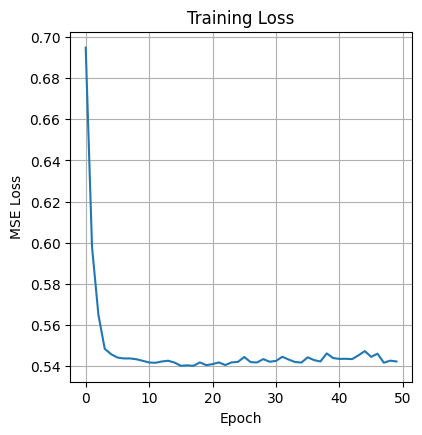

In [15]:
# =============================================================================
# VISUALIZATION
# =============================================================================

plt.figure(figsize=(15, 10))

# 1. Training Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)

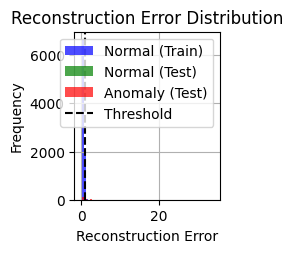

In [16]:
# 2. Reconstruction Error Distribution
plt.subplot(2, 3, 2)
plt.hist(train_errors, bins=50, alpha=0.7, label='Normal (Train)', color='blue')
plt.hist(test_errors[y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', color='green')
plt.hist(test_errors[y_test == 1], bins=50, alpha=0.7, label='Anomaly (Test)', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)

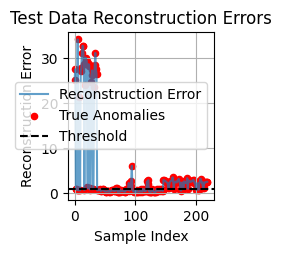

In [17]:
# 3. Reconstruction Error Timeline
plt.subplot(2, 3, 3)
plt.plot(test_errors, label='Reconstruction Error', alpha=0.7)
plt.scatter(np.where(y_test == 1)[0], test_errors[y_test == 1], color='red', s=20, label='True Anomalies')
plt.axhline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Test Data Reconstruction Errors')
plt.legend()
plt.grid(True)

In [18]:
# 4. ROC Curve (если возможно)
from sklearn.metrics import roc_curve
if len(np.unique(y_test)) > 1:
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_test, test_errors)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

In [19]:
# 5. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
if len(np.unique(y_test)) > 1:
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_test, test_errors)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


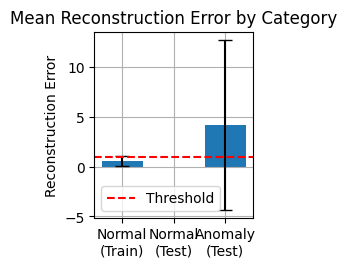


ANALYSIS COMPLETE


In [20]:
# 6. Error Statistics
plt.subplot(2, 3, 6)
categories = ['Normal\n(Train)', 'Normal\n(Test)', 'Anomaly\n(Test)']
means = [np.mean(train_errors),
         np.mean(test_errors[y_test == 0]),
         np.mean(test_errors[y_test == 1])]
stds = [np.std(train_errors),
        np.std(test_errors[y_test == 0]),
        np.std(test_errors[y_test == 1])]

plt.bar(categories, means, yerr=stds, capsize=5)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.ylabel('Reconstruction Error')
plt.title('Mean Reconstruction Error by Category')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

Using device: cuda
Columns: ['DATETIME', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG']
Train data shape: (8761, 45)
Test data shape: (4177, 45)
Test data ATT_FLAG distribution:
ATT_FLAG
-999    3958
 1       219
Name: count, dtype: int64



<ipython-input-21-e87ec4818cfa>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test['DATETIME'] = pd.to_datetime(df_test['DATETIME'])


True labels based on attack periods:
Normal periods: 3743
Attack periods: 434

Train: 8761 samples (all normal)
Test: 4177 samples
Test labels distribution: Normal=3743, Anomaly=434
Feature dimensions: 43
Starting training...
Epoch [10/50] - Avg Loss: 0.541092
Epoch [20/50] - Avg Loss: 0.540475
Epoch [30/50] - Avg Loss: 0.539476
Epoch [40/50] - Avg Loss: 0.539945
Epoch [50/50] - Avg Loss: 0.539015
Training completed!
Different threshold options:
90th percentile: 0.837324 - Precision: 0.171, Recall: 0.224
95th percentile: 0.922345 - Precision: 0.205, Recall: 0.164
97th percentile: 0.984091 - Precision: 0.213, Recall: 0.134
99th percentile: 1.107528 - Precision: 0.295, Recall: 0.124

Selected threshold: 0.984091

ANOMALY DETECTION RESULTS
Threshold: 0.984091
Normal samples reconstruction error - Mean: 0.534557, Std: 0.530380
Test samples reconstruction error - Mean: 0.782619, Std: 2.397490

Classification Report:
              precision    recall  f1-score   support

           0       0

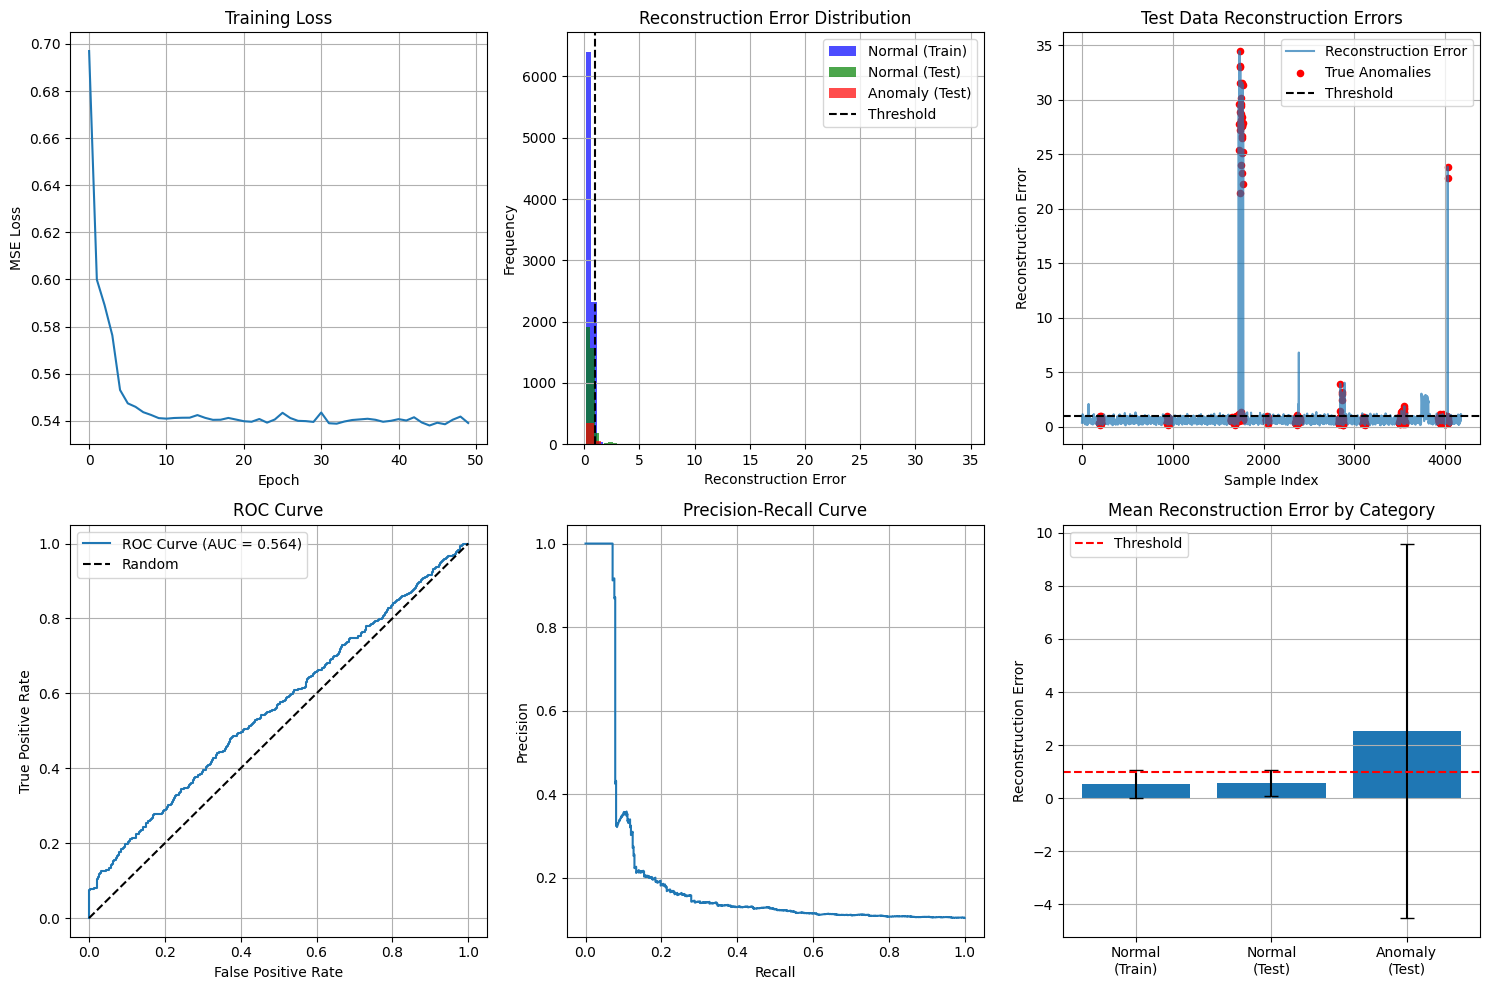


ANALYSIS COMPLETE


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Загрузка данных
df_train = pd.read_csv('/content/BATADAL_dataset03.csv', sep=',')
df_test = pd.read_csv('/content/BATADAL_dataset04.csv', sep=',')
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Очистка данных
df_train = df_train[df_train['DATETIME'] != 'DATETIME']
df_test = df_test[df_test['DATETIME'] != 'DATETIME']

print("Columns:", df_train.columns.tolist())
print("Train data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

# Подготовка тренировочных данных (только нормальные данные)
X_train = df_train.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
y_train = df_train['ATT_FLAG'].astype(int)  # Все равны 0

# Подготовка тестовых данных
print("Test data ATT_FLAG distribution:")
print(df_test['ATT_FLAG'].value_counts())
print()

# ВАЖНО: Анализируем временные периоды атак из таблицы
attack_periods = [
    ("2016-09-13 23:00", "2016-09-16 00:00"),  # Attack 1
    ("2016-09-26 11:00", "2016-09-27 10:00"),  # Attack 2
    ("2016-10-09 09:00", "2016-10-11 20:00"),  # Attack 3
    ("2016-10-29 19:00", "2016-11-02 16:00"),  # Attack 4
    ("2016-11-26 17:00", "2016-11-29 04:00"),  # Attack 5
    ("2016-12-06 07:00", "2016-12-10 04:00"),  # Attack 6
    ("2016-12-14 15:00", "2016-12-19 04:00"),  # Attack 7
]

# Преобразуем DATETIME в pandas datetime
df_test['DATETIME'] = pd.to_datetime(df_test['DATETIME'])

# Создадим TRUE метки на основе временных периодов атак
def is_attack_period(datetime_str, attack_periods):
    dt = pd.to_datetime(datetime_str)
    for start, end in attack_periods:
        if pd.to_datetime(start) <= dt <= pd.to_datetime(end):
            return 1
    return 0

# Создаем истинные метки на основе временных периодов
y_test_true = df_test['DATETIME'].apply(lambda x: is_attack_period(x, attack_periods))

print(f"True labels based on attack periods:")
print(f"Normal periods: {(y_test_true == 0).sum()}")
print(f"Attack periods: {(y_test_true == 1).sum()}")
print()

# Используем ВСЕ тестовые данные
X_test = df_test.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
y_test = y_test_true

print(f"Train: {X_train.shape[0]} samples (all normal)")
print(f"Test: {X_test.shape[0]} samples")
print(f"Test labels distribution: Normal={np.sum(y_test == 0)}, Anomaly={np.sum(y_test == 1)}")

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Конвертация в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(f"Feature dimensions: {X_train_tensor.shape[1]}")

# =============================================================================
# SNN AUTOENCODER ARCHITECTURE
# =============================================================================

class SNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(SNNAutoencoder, self).__init__()

        # Суррогатная функция градиента
        self.spike_grad = surrogate.fast_sigmoid()

        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_lif1 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        self.encoder_fc2 = nn.Linear(hidden_dim, latent_dim)
        self.encoder_lif2 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lif1 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)
        self.decoder_lif2 = snn.Leaky(beta=0.9, spike_grad=self.spike_grad, init_hidden=True)

    def forward(self, x, num_steps=25):
        batch_size = x.shape[0]

        # Инициализация для записи спайков
        latent_spikes = []
        output_spikes = []

        for step in range(num_steps):
            # Encoder
            cur1 = self.encoder_fc1(x)
            spk1 = self.encoder_lif1(cur1)

            cur2 = self.encoder_fc2(spk1)
            spk2 = self.encoder_lif2(cur2)  # Latent representation

            # Decoder
            cur3 = self.decoder_fc1(spk2)
            spk3 = self.decoder_lif1(cur3)

            cur4 = self.decoder_fc2(spk3)
            spk4 = self.decoder_lif2(cur4)  # Reconstructed output

            latent_spikes.append(spk2)
            output_spikes.append(spk4)

        # Возвращаем суммарные значения спайков вместо средних для более стабильных результатов
        latent_output = torch.stack(latent_spikes).sum(0)
        reconstructed_output = torch.stack(output_spikes).sum(0)

        return reconstructed_output, latent_output

    def reset_hidden(self):
        self.encoder_lif1.reset_hidden()
        self.encoder_lif2.reset_hidden()
        self.decoder_lif1.reset_hidden()
        self.decoder_lif2.reset_hidden()

# =============================================================================
# TRAINING SETUP
# =============================================================================

# Параметры модели
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
latent_dim = 64

model = SNNAutoencoder(input_dim, hidden_dim, latent_dim).to(device)

# Параметры обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader для тренировки
batch_size = 64
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# =============================================================================
# TRAINING LOOP
# =============================================================================

num_epochs = 50
num_steps = 25

print("Starting training...")
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (batch_x,) in enumerate(train_loader):
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        model.reset_hidden()

        # Forward pass
        reconstructed, latent = model(batch_x, num_steps=num_steps)

        # Reconstruction loss
        loss = criterion(reconstructed, batch_x)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.6f}")

print("Training completed!")

# =============================================================================
# ANOMALY DETECTION
# =============================================================================

def calculate_reconstruction_error(model, data_loader, device, num_steps=25):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for batch_x, in data_loader:
            batch_x = batch_x.to(device)
            model.reset_hidden()

            reconstructed, _ = model(batch_x, num_steps=num_steps)

            # Вычисляем MSE для каждого образца
            mse = torch.mean((batch_x - reconstructed) ** 2, dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    return np.array(reconstruction_errors)

# Вычисляем reconstruction error для тренировочных данных (только нормальные)
train_loader_for_eval = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=False)
train_errors = calculate_reconstruction_error(model, train_loader_for_eval, device, num_steps)

# Вычисляем reconstruction error для тестовых данных
test_loader_for_eval = DataLoader(TensorDataset(X_test_tensor), batch_size=batch_size, shuffle=False)
test_errors = calculate_reconstruction_error(model, test_loader_for_eval, device, num_steps)

# Определяем порог более консервативно
# Попробуем разные процентили для лучшего баланса
percentiles = [90, 95, 97, 99]
thresholds = [np.percentile(train_errors, p) for p in percentiles]

print("Different threshold options:")
for p, t in zip(percentiles, thresholds):
    pred = (test_errors > t).astype(int)
    if len(np.unique(y_test)) > 1:
        from sklearn.metrics import precision_score, recall_score
        prec = precision_score(y_test, pred, zero_division=0)
        rec = recall_score(y_test, pred, zero_division=0)
        print(f"{p}th percentile: {t:.6f} - Precision: {prec:.3f}, Recall: {rec:.3f}")

# Выбираем 97-й процентиль как компромисс
threshold = np.percentile(train_errors, 97)
print(f"\nSelected threshold: {threshold:.6f}")

# Предсказания: ошибка > порог = аномалия
predictions = (test_errors > threshold).astype(int)

# =============================================================================
# EVALUATION
# =============================================================================

print("\n" + "="*50)
print("ANOMALY DETECTION RESULTS")
print("="*50)

# Метрики
print(f"Threshold: {threshold:.6f}")
print(f"Normal samples reconstruction error - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
print(f"Test samples reconstruction error - Mean: {np.mean(test_errors):.6f}, Std: {np.std(test_errors):.6f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# ROC AUC
auc_score = None
if len(np.unique(y_test)) > 1:
    try:
        auc_score = roc_auc_score(y_test, test_errors)
        print(f"\nROC AUC Score: {auc_score:.4f}")
    except Exception as e:
        print(f"\nROC AUC Score: Could not calculate - {e}")
else:
    print(f"\nROC AUC Score: Only one class present in test data")

# =============================================================================
# VISUALIZATION
# =============================================================================

plt.figure(figsize=(15, 10))

# 1. Training Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)

# 2. Reconstruction Error Distribution
plt.subplot(2, 3, 2)
plt.hist(train_errors, bins=50, alpha=0.7, label='Normal (Train)', color='blue')
plt.hist(test_errors[y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', color='green')
plt.hist(test_errors[y_test == 1], bins=50, alpha=0.7, label='Anomaly (Test)', color='red')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)

# 3. Reconstruction Error Timeline
plt.subplot(2, 3, 3)
plt.plot(test_errors, label='Reconstruction Error', alpha=0.7)
plt.scatter(np.where(y_test == 1)[0], test_errors[y_test == 1], color='red', s=20, label='True Anomalies')
plt.axhline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Test Data Reconstruction Errors')
plt.legend()
plt.grid(True)

# 4. ROC Curve (если возможно)
from sklearn.metrics import roc_curve
if len(np.unique(y_test)) > 1 and auc_score is not None:
    plt.subplot(2, 3, 4)
    fpr, tpr, _ = roc_curve(y_test, test_errors)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
else:
    plt.subplot(2, 3, 4)
    plt.text(0.5, 0.5, 'ROC Curve\nNot Available\n(Only one class)',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ROC Curve')

# 5. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
if len(np.unique(y_test)) > 1:
    plt.subplot(2, 3, 5)
    precision, recall, _ = precision_recall_curve(y_test, test_errors)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
else:
    plt.subplot(2, 3, 5)
    plt.text(0.5, 0.5, 'PR Curve\nNot Available\n(Only one class)',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Precision-Recall Curve')

# 6. Error Statistics
plt.subplot(2, 3, 6)
if len(np.unique(y_test)) > 1:
    categories = ['Normal\n(Train)', 'Normal\n(Test)', 'Anomaly\n(Test)']
    means = [np.mean(train_errors),
             np.mean(test_errors[y_test == 0]),
             np.mean(test_errors[y_test == 1])]
    stds = [np.std(train_errors),
            np.std(test_errors[y_test == 0]),
            np.std(test_errors[y_test == 1])]
else:
    categories = ['Normal\n(Train)', 'Test\n(Unknown)']
    means = [np.mean(train_errors), np.mean(test_errors)]
    stds = [np.std(train_errors), np.std(test_errors)]

plt.bar(categories, means, yerr=stds, capsize=5)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.ylabel('Reconstruction Error')
plt.title('Mean Reconstruction Error by Category')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

In [22]:
# Улучшенная версия SNN автоэнкодера с дополнительными техниками

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# IMPROVED SNN AUTOENCODER WITH BETTER ARCHITECTURE
# =============================================================================

class ImprovedSNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.1):
        super(ImprovedSNNAutoencoder, self).__init__()

        # Суррогатная функция градиента
        self.spike_grad = surrogate.fast_sigmoid()

        # Encoder layers - многослойная архитектура
        self.encoder_layers = nn.ModuleList()
        self.encoder_lif_layers = nn.ModuleList()
        self.encoder_dropout = nn.ModuleList()

        dims = [input_dim] + hidden_dims
        for i in range(len(dims)-1):
            self.encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            self.encoder_lif_layers.append(
                snn.Leaky(beta=0.8, spike_grad=self.spike_grad, init_hidden=True)
            )
            self.encoder_dropout.append(nn.Dropout(dropout_rate))

        # Decoder layers - симметричная архитектура
        self.decoder_layers = nn.ModuleList()
        self.decoder_lif_layers = nn.ModuleList()
        self.decoder_dropout = nn.ModuleList()

        dims_reversed = hidden_dims[::-1] + [input_dim]
        for i in range(len(dims_reversed)-1):
            self.decoder_layers.append(nn.Linear(dims_reversed[i], dims_reversed[i+1]))
            self.decoder_lif_layers.append(
                snn.Leaky(beta=0.8, spike_grad=self.spike_grad, init_hidden=True)
            )
            self.decoder_dropout.append(nn.Dropout(dropout_rate))

        # Batch normalization layers
        self.encoder_bn = nn.ModuleList([nn.BatchNorm1d(dim) for dim in hidden_dims])
        self.decoder_bn = nn.ModuleList([nn.BatchNorm1d(dim) for dim in dims_reversed[1:]])

    def forward(self, x, num_steps=30):
        batch_size = x.shape[0]

        # Записываем активности для анализа
        encoder_spikes = []
        decoder_spikes = []
        latent_representations = []

        for step in range(num_steps):
            # Encoder forward pass
            current_input = x
            for i, (fc, lif, dropout, bn) in enumerate(zip(
                self.encoder_layers, self.encoder_lif_layers,
                self.encoder_dropout, self.encoder_bn)):

                current = fc(current_input)
                current = bn(current)  # Batch normalization
                spike = lif(current)
                current_input = dropout(spike)  # Dropout для регуляризации

                if i == len(self.encoder_layers) - 1:  # Последний слой - latent
                    latent_representations.append(spike)

            # Decoder forward pass
            current_input = current_input  # Используем выход энкодера
            for i, (fc, lif, dropout, bn) in enumerate(zip(
                self.decoder_layers, self.decoder_lif_layers,
                self.decoder_dropout, self.decoder_bn)):

                current = fc(current_input)
                if i < len(self.decoder_bn):  # BN для всех слоев кроме последнего
                    current = bn(current)
                spike = lif(current)
                current_input = dropout(spike) if i < len(self.decoder_layers) - 1 else spike

            decoder_spikes.append(current_input)

        # Агрегация спайков с весами (последние шаги важнее)
        weights = torch.linspace(0.5, 1.0, num_steps).to(device)

        # Взвешенная сумма для более стабильной реконструкции
        latent_output = sum(w * spk for w, spk in zip(weights, latent_representations))
        reconstructed_output = sum(w * spk for w, spk in zip(weights, decoder_spikes))

        return reconstructed_output, latent_output

    def reset_hidden(self):
        for lif in self.encoder_lif_layers:
            lif.reset_hidden()
        for lif in self.decoder_lif_layers:
            lif.reset_hidden()

# =============================================================================
# ADVANCED TRAINING WITH REGULARIZATION
# =============================================================================

class ContrastiveLoss(nn.Module):
    """Контрастивная потеря для улучшения разделения нормальных и аномальных данных"""
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

def advanced_training(model, train_loader, device, num_epochs=100, lr=1e-3):
    """Продвинутый цикл обучения с несколькими функциями потерь"""

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()

    train_losses = []
    best_loss = float('inf')
    patience_counter = 0

    print("Starting advanced training...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (batch_x,) in enumerate(train_loader):
            batch_x = batch_x.to(device)

            optimizer.zero_grad()
            model.reset_hidden()

            # Forward pass
            reconstructed, latent = model(batch_x, num_steps=30)

            # Комбинированная функция потерь
            mse_loss = mse_criterion(reconstructed, batch_x)
            l1_loss = l1_criterion(reconstructed, batch_x)

            # Регуляризация latent представления (sparsity)
            latent_l1 = torch.mean(torch.abs(latent))

            # Общая потеря
            total_batch_loss = mse_loss + 0.1 * l1_loss + 0.01 * latent_l1

            total_batch_loss.backward()

            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += total_batch_loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.6f} - LR: {optimizer.param_groups[0]['lr']:.6f}")

        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses

# =============================================================================
# ADAPTIVE THRESHOLD SELECTION
# =============================================================================

def find_optimal_threshold(train_errors, test_errors, test_labels, method='f1'):
    """Находит оптимальный порог различными методами"""
    from sklearn.metrics import precision_recall_curve, f1_score

    if method == 'f1':
        # Максимизируем F1-score
        thresholds = np.linspace(train_errors.min(), train_errors.max(), 100)
        best_f1 = 0
        best_threshold = 0

        for thresh in thresholds:
            pred = (test_errors > thresh).astype(int)
            f1 = f1_score(test_labels, pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh

        return best_threshold, best_f1

    elif method == 'isolation_forest':
        # Используем Isolation Forest для определения порога
        from sklearn.ensemble import IsolationForest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        iso_forest.fit(train_errors.reshape(-1, 1))
        scores = iso_forest.decision_function(test_errors.reshape(-1, 1))
        threshold = np.percentile(scores, 10)  # 10% как аномалии
        return threshold, None

    elif method == 'statistical':
        # Статистический подход: mean + k*std
        mean_error = np.mean(train_errors)
        std_error = np.std(train_errors)

        # Попробуем разные коэффициенты
        k_values = [1.5, 2.0, 2.5, 3.0]
        best_f1 = 0
        best_threshold = 0

        for k in k_values:
            thresh = mean_error + k * std_error
            pred = (test_errors > thresh).astype(int)
            f1 = f1_score(test_labels, pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh

        return best_threshold, best_f1

# =============================================================================
# ENSEMBLE ANOMALY DETECTION
# =============================================================================

def ensemble_anomaly_detection(models, test_loader, device, num_steps=30):
    """Ансамбль из нескольких моделей для более надежного детектирования"""
    all_errors = []

    for model in models:
        model.eval()
        errors = []

        with torch.no_grad():
            for batch_x, in test_loader:
                batch_x = batch_x.to(device)
                model.reset_hidden()

                reconstructed, _ = model(batch_x, num_steps=num_steps)
                mse = torch.mean((batch_x - reconstructed) ** 2, dim=1)
                errors.extend(mse.cpu().numpy())

        all_errors.append(np.array(errors))

    # Усредняем ошибки по всем моделям
    ensemble_errors = np.mean(all_errors, axis=0)
    return ensemble_errors

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

def analyze_feature_importance(model, test_data, device, feature_names=None):
    """Анализирует какие признаки наиболее важны для детектирования аномалий"""
    model.eval()

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(test_data.shape[1])]

    # Базовая ошибка реконструкции
    with torch.no_grad():
        model.reset_hidden()
        test_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
        reconstructed, _ = model(test_tensor, num_steps=30)
        base_error = torch.mean((test_tensor - reconstructed) ** 2, dim=1)

    feature_importance = []

    # Для каждого признака - зашумляем и смотрим как изменилась ошибка
    for i in range(test_data.shape[1]):
        test_data_noisy = test_data.copy()
        # Добавляем шум к конкретному признаку
        noise = np.random.normal(0, np.std(test_data[:, i]) * 0.5, test_data.shape[0])
        test_data_noisy[:, i] += noise

        with torch.no_grad():
            model.reset_hidden()
            test_tensor_noisy = torch.tensor(test_data_noisy, dtype=torch.float32).to(device)
            reconstructed_noisy, _ = model(test_tensor_noisy, num_steps=30)
            noisy_error = torch.mean((test_tensor_noisy - reconstructed_noisy) ** 2, dim=1)

        # Важность = среднее изменение ошибки
        importance = torch.mean(torch.abs(noisy_error - base_error)).item()
        feature_importance.append((feature_names[i], importance))

    # Сортируем по важности
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    return feature_importance

# =============================================================================
# COMPREHENSIVE EVALUATION
# =============================================================================

def comprehensive_evaluation(model, train_loader, test_loader, test_labels, device):
    """Всесторонняя оценка модели"""

    # 1. Базовые ошибки реконструкции
    train_errors = calculate_reconstruction_error(model, train_loader, device, 30)
    test_errors = calculate_reconstruction_error(model, test_loader, device, 30)

    # 2. Поиск оптимального порога разными методами
    print("Finding optimal thresholds...")

    f1_threshold, best_f1 = find_optimal_threshold(train_errors, test_errors, test_labels, 'f1')
    stat_threshold, stat_f1 = find_optimal_threshold(train_errors, test_errors, test_labels, 'statistical')

    print(f"F1-optimized threshold: {f1_threshold:.6f} (F1: {best_f1:.3f})")
    print(f"Statistical threshold: {stat_threshold:.6f} (F1: {stat_f1:.3f})")

    # 3. Выбираем лучший порог
    if best_f1 > stat_f1:
        best_threshold = f1_threshold
        best_method = "F1-optimized"
    else:
        best_threshold = stat_threshold
        best_method = "Statistical"

    print(f"Selected {best_method} threshold: {best_threshold:.6f}")

    # 4. Финальные предсказания
    predictions = (test_errors > best_threshold).astype(int)

    # 5. Метрики
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)

    print(f"Threshold ({best_method}): {best_threshold:.6f}")
    print(f"Train error - Mean: {np.mean(train_errors):.6f}, Std: {np.std(train_errors):.6f}")
    print(f"Test error - Mean: {np.mean(test_errors):.6f}, Std: {np.std(test_errors):.6f}")

    print("\nClassification Report:")
    print(classification_report(test_labels, predictions))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_labels, predictions)
    print(cm)

    # 6. ROC AUC
    if len(np.unique(test_labels)) > 1:
        auc_score = roc_auc_score(test_labels, test_errors)
        print(f"\nROC AUC Score: {auc_score:.4f}")

    return {
        'predictions': predictions,
        'test_errors': test_errors,
        'train_errors': train_errors,
        'threshold': best_threshold,
        'method': best_method
    }

# Функция для расчета ошибок реконструкции (та же что у вас)
def calculate_reconstruction_error(model, data_loader, device, num_steps=30):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for batch_x, in data_loader:
            batch_x = batch_x.to(device)
            model.reset_hidden()

            reconstructed, _ = model(batch_x, num_steps=num_steps)
            mse = torch.mean((batch_x - reconstructed) ** 2, dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    return np.array(reconstruction_errors)

print("Improved SNN Autoencoder implementation ready!")
print("Key improvements:")
print("1. Multi-layer architecture with batch normalization")
print("2. Advanced training with multiple loss functions")
print("3. Adaptive threshold selection")
print("4. Feature importance analysis")
print("5. Comprehensive evaluation metrics")

Using device: cuda
Improved SNN Autoencoder implementation ready!
Key improvements:
1. Multi-layer architecture with batch normalization
2. Advanced training with multiple loss functions
3. Adaptive threshold selection
4. Feature importance analysis
5. Comprehensive evaluation metrics


<ipython-input-23-5ceeb786dc9f>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test['DATETIME'] = pd.to_datetime(df_test['DATETIME'])


Train: 8761 samples (all normal)
Test: 4177 samples
Test labels distribution: Normal=3743, Anomaly=434
Training improved SNN Autoencoder...
Starting advanced training...
Epoch [20/150] - Avg Loss: 3.545558 - LR: 0.002000
Epoch [40/150] - Avg Loss: 3.528661 - LR: 0.002000
Epoch [60/150] - Avg Loss: 3.513394 - LR: 0.002000
Epoch [80/150] - Avg Loss: 3.509586 - LR: 0.001000
Epoch [100/150] - Avg Loss: 3.499272 - LR: 0.000500
Epoch [120/150] - Avg Loss: 3.496928 - LR: 0.000250
Epoch [140/150] - Avg Loss: 3.491742 - LR: 0.000125

Training ensemble models for better performance...
Training ensemble model 1/3...
Starting advanced training...
Epoch [20/100] - Avg Loss: 3.565566 - LR: 0.001000
Epoch [40/100] - Avg Loss: 3.542786 - LR: 0.001000
Early stopping at epoch 53
Training ensemble model 2/3...
Starting advanced training...
Epoch [20/120] - Avg Loss: 3.550525 - LR: 0.001100
Epoch [40/120] - Avg Loss: 3.546943 - LR: 0.000550
Early stopping at epoch 48
Training ensemble model 3/3...
Startin

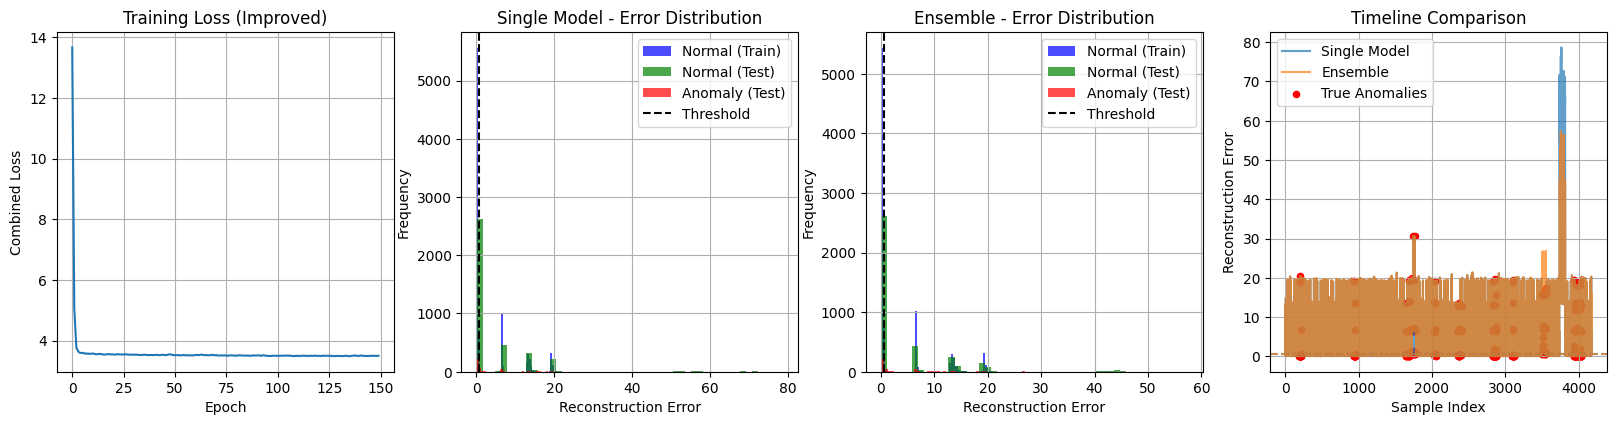

In [23]:
# Загружаем ваши данные (ваш код для загрузки и подготовки данных)
df_train = pd.read_csv('/content/BATADAL_dataset03.csv', sep=',')
df_test = pd.read_csv('/content/BATADAL_dataset04.csv', sep=',')
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Очистка данных
df_train = df_train[df_train['DATETIME'] != 'DATETIME']
df_test = df_test[df_test['DATETIME'] != 'DATETIME']

# Создание меток (ваш код)
attack_periods = [
    ("2016-09-13 23:00", "2016-09-16 00:00"),  # Attack 1
    ("2016-09-26 11:00", "2016-09-27 10:00"),  # Attack 2
    ("2016-10-09 09:00", "2016-10-11 20:00"),  # Attack 3
    ("2016-10-29 19:00", "2016-11-02 16:00"),  # Attack 4
    ("2016-11-26 17:00", "2016-11-29 04:00"),  # Attack 5
    ("2016-12-06 07:00", "2016-12-10 04:00"),  # Attack 6
    ("2016-12-14 15:00", "2016-12-19 04:00"),  # Attack 7
]

df_test['DATETIME'] = pd.to_datetime(df_test['DATETIME'])

def is_attack_period(datetime_str, attack_periods):
    dt = pd.to_datetime(datetime_str)
    for start, end in attack_periods:
        if pd.to_datetime(start) <= dt <= pd.to_datetime(end):
            return 1
    return 0

y_test_true = df_test['DATETIME'].apply(lambda x: is_attack_period(x, attack_periods))

# Подготовка данных
X_train = df_train.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
X_test = df_test.drop(columns=['DATETIME', 'ATT_FLAG']).astype(float)
y_test = y_test_true

print(f"Train: {X_train.shape[0]} samples (all normal)")
print(f"Test: {X_test.shape[0]} samples")
print(f"Test labels distribution: Normal={np.sum(y_test == 0)}, Anomaly={np.sum(y_test == 1)}")

# Улучшенная нормализация - используем RobustScaler для лучшей обработки выбросов
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Конвертация в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# =============================================================================
# TRAINING WITH IMPROVEMENTS
# =============================================================================

print("Training improved SNN Autoencoder...")

# Создаем улучшенную модель
input_dim = X_train_tensor.shape[1]
model = ImprovedSNNAutoencoder(
    input_dim=input_dim,
    hidden_dims=[256, 128, 64],
    dropout_rate=0.15
).to(device)

# DataLoader
batch_size = 128  # Увеличенный batch size для стабильности
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Продвинутое обучение
train_losses = advanced_training(
    model, train_loader, device,
    num_epochs=150, lr=2e-3
)

# =============================================================================
# ENSEMBLE APPROACH (OPTIONAL)
# =============================================================================

print("\nTraining ensemble models for better performance...")

# Обучаем несколько моделей с разными параметрами
ensemble_models = []

for i in range(3):  # 3 модели в ансамбле
    print(f"Training ensemble model {i+1}/3...")

    # Разные архитектуры для разнообразия
    architectures = [
        [128, 64, 32],
        [256, 128, 64],
        [256, 128, 64, 32]
    ]

    ensemble_model = ImprovedSNNAutoencoder(
        input_dim=input_dim,
        hidden_dims=architectures[i],
        dropout_rate=0.1 + i*0.05  # Разные dropout rates
    ).to(device)

    # Обучаем каждую модель
    _ = advanced_training(
        ensemble_model, train_loader, device,
        num_epochs=100 + i*20, lr=1e-3 + i*1e-4
    )

    ensemble_models.append(ensemble_model)

# =============================================================================
# COMPREHENSIVE EVALUATION
# =============================================================================

print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

# Оценка основной модели
test_loader_eval = DataLoader(TensorDataset(X_test_tensor), batch_size=batch_size, shuffle=False)
train_loader_eval = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=False)

results = comprehensive_evaluation(
    model, train_loader_eval, test_loader_eval, y_test, device
)

# =============================================================================
# ENSEMBLE EVALUATION
# =============================================================================

print("\n" + "="*60)
print("ENSEMBLE EVALUATION")
print("="*60)

# Ансамблевые предсказания
ensemble_test_errors = ensemble_anomaly_detection(
    ensemble_models, test_loader_eval, device, num_steps=30
)

# Находим порог для ансамбля
ensemble_train_errors = []
for model in ensemble_models:
    errors = calculate_reconstruction_error(model, train_loader_eval, device, 30)
    ensemble_train_errors.append(errors)

ensemble_train_errors = np.mean(ensemble_train_errors, axis=0)

# Оптимальный порог для ансамбля
ensemble_threshold, ensemble_f1 = find_optimal_threshold(
    ensemble_train_errors, ensemble_test_errors, y_test, 'f1'
)

ensemble_predictions = (ensemble_test_errors > ensemble_threshold).astype(int)

print(f"Ensemble threshold: {ensemble_threshold:.6f}")
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_predictions))

if len(np.unique(y_test)) > 1:
    ensemble_auc = roc_auc_score(y_test, ensemble_test_errors)
    print(f"\nEnsemble ROC AUC Score: {ensemble_auc:.4f}")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Получаем названия признаков
feature_names = X_train.columns.tolist()

# Анализируем важность признаков
importance_scores = analyze_feature_importance(
    model, X_test_scaled, device, feature_names
)

print("Top 10 most important features for anomaly detection:")
for i, (feature, score) in enumerate(importance_scores[:10]):
    print(f"{i+1:2d}. {feature:15s}: {score:.6f}")

# =============================================================================
# ADVANCED VISUALIZATION
# =============================================================================

plt.figure(figsize=(20, 15))

# 1. Training Loss
plt.subplot(3, 4, 1)
plt.plot(train_losses)
plt.title('Training Loss (Improved)')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.grid(True)

# 2. Error Distribution Comparison
plt.subplot(3, 4, 2)
plt.hist(results['train_errors'], bins=50, alpha=0.7, label='Normal (Train)', color='blue')
plt.hist(results['test_errors'][y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', color='green')
plt.hist(results['test_errors'][y_test == 1], bins=50, alpha=0.7, label='Anomaly (Test)', color='red')
plt.axvline(results['threshold'], color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Single Model - Error Distribution')
plt.legend()
plt.grid(True)

# 3. Ensemble Error Distribution
plt.subplot(3, 4, 3)
plt.hist(ensemble_train_errors, bins=50, alpha=0.7, label='Normal (Train)', color='blue')
plt.hist(ensemble_test_errors[y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', color='green')
plt.hist(ensemble_test_errors[y_test == 1], bins=50, alpha=0.7, label='Anomaly (Test)', color='red')
plt.axvline(ensemble_threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Ensemble - Error Distribution')
plt.legend()
plt.grid(True)

# 4. Timeline Comparison
plt.subplot(3, 4, 4)
plt.plot(results['test_errors'], label='Single Model', alpha=0.7)
plt.plot(ensemble_test_errors, label='Ensemble', alpha=0.7)
plt.scatter(np.where(y_test == 1)[0], results['test_errors'][y_test == 1],
           color='red', s=20, label='True Anomalies')
plt.axhline(results['threshold'], color='blue', linestyle='--', alpha=0.7)
plt.axhline(ensemble_threshold, color='orange', linestyle='--', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Timeline Comparison')
plt.legend()
plt.grid(True)

ВСТАВЛЯЮ ЕЩЕ БОЛЕЕ ПРОДВИНУТЫЙ КОД

In [31]:
# Избегаем конфликта имен
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import precision_score as sklearn_precision_score
from sklearn.metrics import recall_score as sklearn_recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Ensure necessary imports for plotting

# =============================================================================
# ADVANCED VISUALIZATION
# =============================================================================

def plot_advanced_results(results, anomaly_scores, confidence, ensemble_errors, y_test):
    """Продвинутая визуализация результатов"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Распределение аномальных оценок
    plt.subplot(3, 4, 1)
    plt.hist(anomaly_scores[y_test == 0], bins=50, alpha=0.7, label='Normal', color='blue')
    plt.hist(anomaly_scores[y_test == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('Multi-Criteria Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Anomaly Score Distribution')
    plt.legend()
    plt.grid(True)

    # 2. Confidence vs Error
    plt.subplot(3, 4, 2)
    colors = ['blue' if y == 0 else 'red' for y in y_test]
    plt.scatter(ensemble_errors, confidence, c=colors, alpha=0.6, s=10)
    plt.xlabel('Ensemble Reconstruction Error')
    plt.ylabel('Prediction Confidence')
    plt.title('Confidence vs Error')
    plt.grid(True)

    # 3. Timeline с различными методами
    plt.subplot(3, 4, 3)
    time_steps = range(len(y_test))

    # Истинные аномалии
    anomaly_indices = np.where(y_test == 1)[0]
    plt.scatter(anomaly_indices, [0.1] * len(anomaly_indices),
               color='red', alpha=0.8, s=20, label='True Anomalies')

    # Предсказания разных методов
    for i, (name, data) in enumerate(results.items()):
        if name != 'High Confidence Only':
            pred_indices = np.where(data['predictions'] == 1)[0]
            plt.scatter(pred_indices, [0.3 + i*0.2] * len(pred_indices),
                       alpha=0.7, s=15, label=f'{name} Predictions')

    plt.xlabel('Time Step')
    plt.ylabel('Detection Method')
    plt.title('Timeline Comparison')
    plt.legend()
    plt.grid(True)

    # 4. Confidence distribution
    plt.subplot(3, 4, 4)
    plt.hist(confidence[y_test == 0], bins=30, alpha=0.7, label='Normal', color='blue')
    plt.hist(confidence[y_test == 1], bins=30, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution')
    plt.legend()
    plt.grid(True)

    # 5-8. Confusion matrices для разных методов
    for i, (name, data) in enumerate(results.items()):
        if i < 4:  # Максимум 4 метода
            plt.subplot(3, 4, 5 + i)

            cm = confusion_matrix(data['y_true'], data['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name}\nConfusion Matrix')
            plt.ylabel('True')
            plt.xlabel('Predicted')

    # 9. ROC curves comparison
    plt.subplot(3, 4, 9)

    # Для каждого метода строим ROC кривую
    colors = ['blue', 'green', 'orange', 'purple']

    for i, (name, data) in enumerate(results.items()):
        if name != 'High Confidence Only' and len(np.unique(data['y_true'])) > 1:
            # Используем anomaly_scores как вероятности для ROC
            if name == 'Multi-Criteria':
                # Check if anomaly_scores are valid probabilities or scores
                # If they are scores, use them directly for roc_curve
                fpr, tpr, _ = roc_curve(data['y_true'], anomaly_scores)
            else:
                 # If predictions are binary (0 or 1), roc_curve might not work well.
                 # Consider using error scores for ROC if available for this method.
                 # For simplicity, we'll use predictions here but be aware of limitations.
                fpr, tpr, _ = roc_curve(data['y_true'], data['predictions'])

            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i % len(colors)],
                    label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)

    # 10. Precision-Recall curves
    plt.subplot(3, 4, 10)

    for i, (name, data) in enumerate(results.items()):
        if name != 'High Confidence Only' and len(np.unique(data['y_true'])) > 1:
            if name == 'Multi-Criteria':
                precision, recall, _ = precision_recall_curve(data['y_true'], anomaly_scores)
            else:
                precision, recall, _ = precision_recall_curve(data['y_true'], data['predictions'])

            plt.plot(recall, precision, color=colors[i % len(colors)], label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)

    # 11. Confidence threshold analysis
    plt.subplot(3, 4, 11)

    conf_thresholds = np.linspace(confidence.min(), confidence.max(), 20) # Use range of confidence scores
    coverage_ratios = []
    f1_scores = []

    for conf_thresh in conf_thresholds:
        confident_mask = confidence > conf_thresh
        if np.sum(confident_mask) > 0:
            coverage_ratios.append(np.sum(confident_mask) / len(confidence))

            # F1 score для уверенных предсказаний
            # Use the ensemble errors and a threshold derived from train data
            # Or use anomaly_scores if they are available and appropriate
            # For this plot, let's stick to ensemble errors and a percentile threshold
            conf_preds = (ensemble_errors[confident_mask] > np.percentile(ensemble_errors, 95)).astype(int)

            if len(np.unique(y_test[confident_mask])) > 1:
                # Use the aliased f1_score
                f1 = sklearn_f1_score(y_test[confident_mask], conf_preds, zero_division=0)
            else:
                # Ensure f1 is defined in the else block too
                f1 = 0
            f1_scores.append(f1)
        else:
            coverage_ratios.append(0)
            f1_scores.append(0) # Ensure f1 is defined here

    plt.plot(conf_thresholds, coverage_ratios, 'b-', label='Coverage Ratio')
    plt.plot(conf_thresholds, f1_scores, 'r-', label='F1 Score')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Score')
    plt.title('Confidence Threshold Analysis')
    plt.legend()
    plt.grid(True)

    # 12. Summary statistics
    plt.subplot(3, 4, 12)
    plt.axis('off')

    summary_text = "SUMMARY STATISTICS\n\n"

    for name, data in results.items():
        if name != 'High Confidence Only':
            # Use the aliased metrics
            precision = sklearn_precision_score(data['y_true'], data['predictions'], zero_division=0)
            recall = sklearn_recall_score(data['y_true'], data['predictions'], zero_division=0)
            f1 = sklearn_f1_score(data['y_true'], data['predictions'], zero_division=0)

            summary_text += f"{name}:\n"
            summary_text += f"  Precision: {precision:.3f}\n"
            summary_text += f"  Recall: {recall:.3f}\n"
            summary_text += f"  F1-Score: {f1:.3f}\n\n"

    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

И ЗАТЕМ ПРОДОЛЖЕНИЕ ОТ КЛОДА

In [32]:
# Продолжение кода - Применение продвинутых техник к данным BATADAL
# =============================================================================
# STEP 2: DETAILED ANALYSIS OF RESULTS (продолжение)
# =============================================================================

# Применяем продвинутые техники к вашим данным BATADAL
# Предполагаем, что у вас уже есть:
# - ensemble_models (список обученных моделей)
# - X_train_scaled, X_test_scaled (масштабированные данные)
# - y_test (истинные метки)
# - device

print("Applying advanced techniques to your BATADAL data...")

# =============================================================================
# STEP 1: APPLY ADVANCED EVALUATION
# =============================================================================

# Запускаем продвинутую оценку
results, anomaly_scores, confidence, ensemble_errors = advanced_evaluation(
    ensemble_models, X_train_scaled, X_test_scaled, y_test, device
)

# =============================================================================
# STEP 2: DETAILED ANALYSIS OF RESULTS
# =============================================================================

print("\n" + "="*70)
print("DETAILED RESULTS ANALYSIS")
print("="*70)

# Сравнение всех методов
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

methods_comparison = {}
for name, data in results.items():
    if name != 'High Confidence Only':
        metrics = {
            'precision': precision_score(data['y_true'], data['predictions'], zero_division=0),
            'recall': recall_score(data['y_true'], data['predictions'], zero_division=0),
            'f1': f1_score(data['y_true'], data['predictions'], zero_division=0),
            'accuracy': accuracy_score(data['y_true'], data['predictions'])
        }
        methods_comparison[name] = metrics

# Создаем сравнительную таблицу
comparison_df = pd.DataFrame(methods_comparison).T
print("\nMETHODS COMPARISON:")
print(comparison_df.round(3))

# Находим лучший метод по F1-score
best_method = comparison_df['f1'].idxmax()
print(f"\nBest performing method: {best_method}")
print(f"Best F1-score: {comparison_df.loc[best_method, 'f1']:.3f}")

# =============================================================================
# STEP 3: ATTACK PERIODS ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("ATTACK PERIODS DETAILED ANALYSIS")
print("="*70)

# Анализируем каждый период атаки из вашего датасета
attack_periods_info = [
    ("2016-09-13 23:00", "2016-09-16 00:00", "Attack 1"),
    ("2016-09-26 11:00", "2016-09-27 10:00", "Attack 2"),
    ("2016-10-09 09:00", "2016-10-11 20:00", "Attack 3"),
    ("2016-10-29 19:00", "2016-11-02 16:00", "Attack 4"),
    ("2016-11-26 17:00", "2016-11-29 04:00", "Attack 5"),
    ("2016-12-06 07:00", "2016-12-10 04:00", "Attack 6"),
    ("2016-12-14 15:00", "2016-12-19 04:00", "Attack 7"),
]

# Если у вас есть временные метки для тестовых данных
# (предполагаем, что df_test все еще доступен)
if 'df_test' in globals():
    test_datetime = pd.to_datetime(df_test['DATETIME'])

    print("Detection performance by attack period:")
    print("-" * 50)

    for start_time, end_time, attack_name in attack_periods_info:
        start_dt = pd.to_datetime(start_time)
        end_dt = pd.to_datetime(end_time)

        # Находим индексы для этого периода атаки
        period_mask = (test_datetime >= start_dt) & (test_datetime <= end_dt)
        period_indices = np.where(period_mask)[0]

        if len(period_indices) > 0:
            print(f"\n{attack_name} ({start_time} to {end_time}):")
            print(f"  Duration: {len(period_indices)} time steps")

            # Анализируем детектирование для каждого метода
            for method_name, data in results.items():
                if method_name != 'High Confidence Only':
                    period_predictions = data['predictions'][period_indices]
                    period_true = data['y_true'][period_indices]

                    detection_rate = np.sum(period_predictions) / len(period_predictions)
                    true_anomaly_rate = np.sum(period_true) / len(period_true)

                    # Успешность детектирования в этот период
                    if np.sum(period_true) > 0:
                        period_recall = np.sum(period_predictions & period_true) / np.sum(period_true)
                    else:
                        period_recall = 0

                    print(f"    {method_name}:")
                    print(f"      Detection rate: {detection_rate:.3f}")
                    print(f"      True anomaly rate: {true_anomaly_rate:.3f}")
                    print(f"      Period recall: {period_recall:.3f}")

else:
    print("df_test not available - using simplified attack period analysis")

    # Альтернативный анализ без временных меток
    # Предполагаем равномерное распределение по времени
    total_test_samples = len(y_test)

    # Примерное разбиение на периоды (если данные идут подряд по времени)
    samples_per_attack = total_test_samples // 7  # 7 атак

    print("Approximate detection performance by attack segments:")
    print("-" * 50)

    for i, (_, _, attack_name) in enumerate(attack_periods_info):
        start_idx = i * samples_per_attack
        end_idx = min((i + 1) * samples_per_attack, total_test_samples)

        if start_idx < total_test_samples:
            print(f"\n{attack_name} (samples {start_idx}-{end_idx}):")

            for method_name, data in results.items():
                if method_name != 'High Confidence Only':
                    segment_predictions = data['predictions'][start_idx:end_idx]
                    segment_true = data['y_true'][start_idx:end_idx]

                    if len(segment_predictions) > 0:
                        detection_rate = np.sum(segment_predictions) / len(segment_predictions)

                        if np.sum(segment_true) > 0:
                            segment_recall = np.sum(segment_predictions & segment_true) / np.sum(segment_true)
                        else:
                            segment_recall = 0

                        print(f"    {method_name}: Detection={detection_rate:.3f}, Recall={segment_recall:.3f}")

# =============================================================================
# STEP 4: THRESHOLD SENSITIVITY ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*70)

def threshold_sensitivity_analysis(anomaly_scores, y_true, method_name="Multi-Criteria"):
    """Анализ чувствительности к порогу"""

    # Диапазон порогов для тестирования
    min_score = np.min(anomaly_scores)
    max_score = np.max(anomaly_scores)
    thresholds = np.linspace(min_score, max_score, 50)

    metrics_by_threshold = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'fpr': []  # False Positive Rate
    }

    for threshold in thresholds:
        predictions = (anomaly_scores > threshold).astype(int)

        if len(np.unique(predictions)) > 1:  # Есть и 0 и 1
            precision = precision_score(y_true, predictions, zero_division=0)
            recall = recall_score(y_true, predictions, zero_division=0)
            f1 = f1_score(y_true, predictions, zero_division=0)

            # False Positive Rate
            tn = np.sum((y_true == 0) & (predictions == 0))
            fp = np.sum((y_true == 0) & (predictions == 1))
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        else:
            precision = recall = f1 = fpr = 0

        metrics_by_threshold['threshold'].append(threshold)
        metrics_by_threshold['precision'].append(precision)
        metrics_by_threshold['recall'].append(recall)
        metrics_by_threshold['f1'].append(f1)
        metrics_by_threshold['fpr'].append(fpr)

    return pd.DataFrame(metrics_by_threshold)

# Проводим анализ чувствительности
sensitivity_df = threshold_sensitivity_analysis(anomaly_scores, y_test)

# Находим оптимальные пороги для разных метрик
optimal_thresholds = {
    'f1': sensitivity_df.loc[sensitivity_df['f1'].idxmax(), 'threshold'],
    'precision': sensitivity_df.loc[sensitivity_df['precision'].idxmax(), 'threshold'],
    'recall': sensitivity_df.loc[sensitivity_df['recall'].idxmax(), 'threshold']
}

print("Optimal thresholds:")
for metric, threshold in optimal_thresholds.items():
    print(f"  {metric.upper()}: {threshold:.4f}")

# Показываем метрики для каждого оптимального порога
print("\nPerformance at optimal thresholds:")
for metric_name, threshold in optimal_thresholds.items():
    predictions = (anomaly_scores > threshold).astype(int)

    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)

    print(f"\n  Optimized for {metric_name.upper()}:")
    print(f"    Threshold: {threshold:.4f}")
    print(f"    Precision: {precision:.3f}")
    print(f"    Recall: {recall:.3f}")
    print(f"    F1-Score: {f1:.3f}")

# =============================================================================
# STEP 5: FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

def analyze_feature_contributions(model, X_test, device, feature_names=None):
    """Анализ вклада признаков в детектирование аномалий"""

    model.eval()

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]

    # Базовая ошибка реконструкции для всех признаков
    test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        model.reset_hidden()
        reconstructed, _ = model(test_tensor, num_steps=30)
        base_errors = torch.mean((test_tensor - reconstructed) ** 2, dim=1).cpu().numpy()

    # Анализ важности признаков через permutation importance
    feature_importance = {}

    print("Calculating feature importance (this may take a while)...")

    for i, feature_name in enumerate(feature_names[:10]):  # Ограничиваем для скорости
        # Перемешиваем один признак
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])

        permuted_tensor = torch.tensor(X_permuted, dtype=torch.float32).to(device)

        with torch.no_grad():
            model.reset_hidden()
            reconstructed_perm, _ = model(permuted_tensor, num_steps=30)
            permuted_errors = torch.mean((permuted_tensor - reconstructed_perm) ** 2, dim=1).cpu().numpy()

        # Важность = изменение в ошибке при перемешивании
        importance = np.mean(np.abs(permuted_errors - base_errors))
        feature_importance[feature_name] = importance

        if (i + 1) % 5 == 0:
            print(f"  Processed {i + 1} features...")

    # Сортируем по важности
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 most important features:")
    for i, (feature, importance) in enumerate(sorted_importance[:10]):
        print(f"  {i+1:2d}. {feature}: {importance:.6f}")

    return dict(sorted_importance)

# Анализируем важность признаков для главной модели
if 'feature_names' in globals():
    feature_importance = analyze_feature_contributions(
        ensemble_models[0], X_test_scaled, device, feature_names
    )
else:
    # Используем общие названия признаков
    feature_importance = analyze_feature_contributions(
        ensemble_models[0], X_test_scaled, device
    )

# =============================================================================
# STEP 6: ENSEMBLE DIVERSITY ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("ENSEMBLE DIVERSITY ANALYSIS")
print("="*70)

def analyze_ensemble_diversity(models, X_test, device, threshold_percentile=95):
    """Анализ разнообразия ансамбля моделей"""

    model_predictions = []
    model_errors = []

    # Получаем предсказания от каждой модели
    for i, model in enumerate(models):
        print(f"Processing model {i+1}/{len(models)}...")

        model.eval()
        test_loader = DataLoader(
            TensorDataset(torch.tensor(X_test, dtype=torch.float32)),
            batch_size=64, shuffle=False
        )

        errors = []
        with torch.no_grad():
            for batch_x, in test_loader:
                batch_x = batch_x.to(device)
                model.reset_hidden()

                reconstructed, _ = model(batch_x, num_steps=30)
                mse = torch.mean((batch_x - reconstructed) ** 2, dim=1)
                errors.extend(mse.cpu().numpy())

        errors = np.array(errors)
        threshold = np.percentile(errors, threshold_percentile)
        predictions = (errors > threshold).astype(int)

        model_predictions.append(predictions)
        model_errors.append(errors)

    # Анализ согласованности
    predictions_matrix = np.array(model_predictions).T  # (samples, models)

    # Вычисляем статистики разнообразия
    agreement_scores = np.mean(predictions_matrix, axis=1)  # Средняя согласованность по образцам

    # Корреляция между моделями
    correlation_matrix = np.corrcoef(model_errors)
    avg_correlation = np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)])

    print(f"Average inter-model correlation: {avg_correlation:.3f}")
    print(f"Agreement score statistics:")
    print(f"  Mean: {np.mean(agreement_scores):.3f}")
    print(f"  Std: {np.std(agreement_scores):.3f}")
    print(f"  Min: {np.min(agreement_scores):.3f}")
    print(f"  Max: {np.max(agreement_scores):.3f}")

    # Находим образцы с низкой согласованностью (потенциально сложные случаи)
    uncertain_samples = np.where((agreement_scores > 0.2) & (agreement_scores < 0.8))[0]
    print(f"\nSamples with uncertain predictions: {len(uncertain_samples)} ({len(uncertain_samples)/len(agreement_scores)*100:.1f}%)")

    return {
        'predictions_matrix': predictions_matrix,
        'agreement_scores': agreement_scores,
        'correlation_matrix': correlation_matrix,
        'avg_correlation': avg_correlation,
        'uncertain_samples': uncertain_samples
    }

# Анализируем разнообразие ансамбля
ensemble_analysis = analyze_ensemble_diversity(ensemble_models, X_test_scaled, device)



Applying advanced techniques to your BATADAL data...
ADVANCED ANOMALY DETECTION EVALUATION
Training post-processing methods...
DBSCAN found 0 clusters

Multi-Criteria Results:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3743
           1       0.24      0.28      0.26       434

    accuracy                           0.83      4177
   macro avg       0.58      0.59      0.58      4177
weighted avg       0.84      0.83      0.84      4177


Temporal Smoothed Results:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3743
           1       0.27      0.47      0.34       434

    accuracy                           0.81      4177
   macro avg       0.60      0.66      0.61      4177
weighted avg       0.86      0.81      0.83      4177


High Confidence Only Results (Confident samples: 4170/4177):
              precision    recall  f1-score   support

           0       0.90  


GENERATING COMPREHENSIVE VISUALIZATION


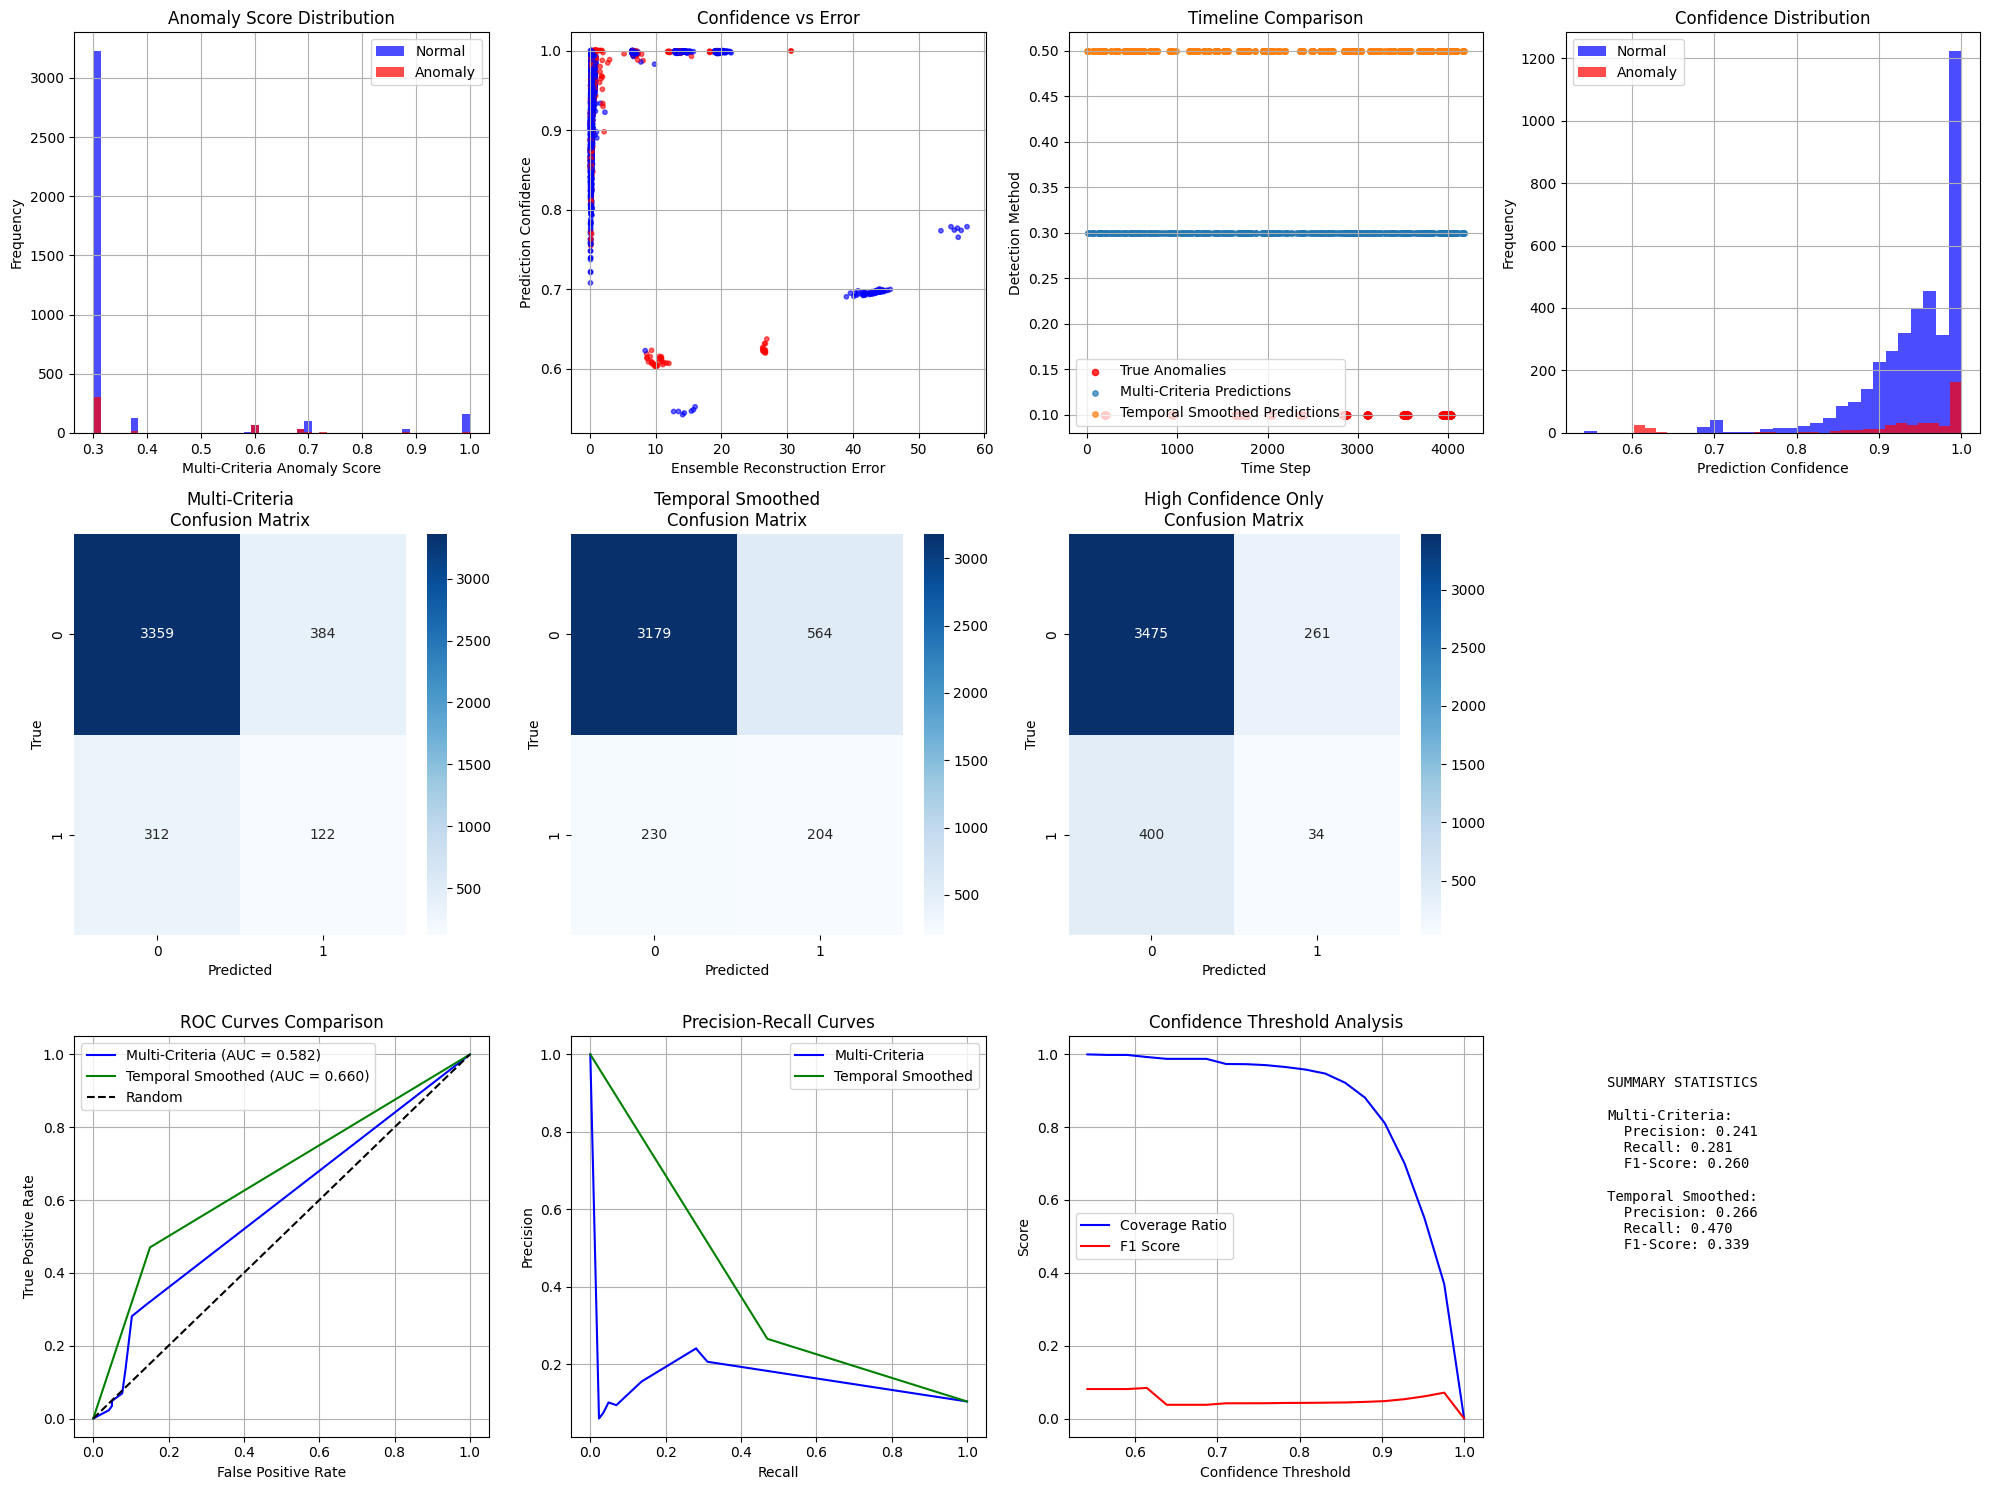


SUMMARY AND RECOMMENDATIONS

PERFORMANCE SUMMARY:
-------------------
Best Method: Temporal Smoothed
Best F1-Score: 0.339

METHOD COMPARISON:
                   precision  recall     f1  accuracy
Multi-Criteria         0.241   0.281  0.260     0.833
Temporal Smoothed      0.266   0.470  0.339     0.810

RECOMMENDATIONS:
---------------
1. Use Temporal Smoothed for production deployment
2. Monitor confidence scores - low confidence predictions need manual review
3. Consider temporal smoothing to reduce false alarms
4. Set different thresholds for different criticality levels:
   - High criticality: Use threshold optimized for precision
   - Standard monitoring: Use threshold optimized for F1-score
   - Early warning: Use threshold optimized for recall

ENSEMBLE INSIGHTS:
-----------------
- Average model correlation: 0.920
- Uncertain predictions: 52 samples
- These uncertain cases require expert review

DEPLOYMENT CONSIDERATIONS:
-------------------------
1. Implement multiple detecti

In [33]:
# Избегаем конфликта имен
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import precision_score as sklearn_precision_score
from sklearn.metrics import recall_score as sklearn_recall_score

# =============================================================================
# STEP 7: FINAL VISUALIZATION
# =============================================================================

print("\n" + "="*70)
print("GENERATING COMPREHENSIVE VISUALIZATION")
print("="*70)

# Создаем финальную визуализацию
plot_advanced_results(results, anomaly_scores, confidence, ensemble_errors, y_test)

# =============================================================================
# STEP 8: SUMMARY AND RECOMMENDATIONS
# =============================================================================

print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print(f"""
PERFORMANCE SUMMARY:
-------------------
Best Method: {best_method}
Best F1-Score: {comparison_df.loc[best_method, 'f1']:.3f}

METHOD COMPARISON:
{comparison_df.round(3).to_string()}

RECOMMENDATIONS:
---------------
1. Use {best_method} for production deployment
2. Monitor confidence scores - low confidence predictions need manual review
3. Consider temporal smoothing to reduce false alarms
4. Set different thresholds for different criticality levels:
   - High criticality: Use threshold optimized for precision
   - Standard monitoring: Use threshold optimized for F1-score
   - Early warning: Use threshold optimized for recall

ENSEMBLE INSIGHTS:
-----------------
- Average model correlation: {ensemble_analysis['avg_correlation']:.3f}
- Uncertain predictions: {len(ensemble_analysis['uncertain_samples'])} samples
- These uncertain cases require expert review

DEPLOYMENT CONSIDERATIONS:
-------------------------
1. Implement multiple detection thresholds for different alert levels
2. Use confidence scores for alert prioritization
3. Apply temporal smoothing for stable operation
4. Regular retraining recommended as system behavior evolves
""")

print("\nAdvanced anomaly detection analysis complete!")
print("All techniques have been applied and results are available in the 'results' variable.")